# AI Challenge - Prediction of Spatial Cellular Organization from Histology Images

## Problem Statement
Map the spatial distribution of biological cell types in a tissue slice from routine Histology HE slides.

## Introduction & Background
Histology is a century-old technique critical for clinical diagnosis. However, its interpretation is subjective, time-consuming, and limited to coarse-grained features. In contrast, genomic deep sequencing and spatial transcriptomics provide rich molecular details but are cost-prohibitive and technically demanding.

This challenge invites participants to bridge this gap by predicting cell-type composition directly from HE images, leveraging machine learning to infer spatial patterns of biological signals from routine data.

## Core Challenge
Design a computational pipeline to predict the spatially resolved cell-type composition of a tissue sample. For each spot (~55 μm in diameter), the goal is to predict the abundances of **35 cell types** using image data alone.

## Submission Requirements
- Notebook submissions with run-time ≤ 9 hours (CPU or GPU).
- No external data – only the provided training set and public models/libraries.
- The submission file must be named `submission.csv` and follow the format:
  `ID,C1,C2,...,C35`
  where C1-C35 are the predicted cell-type abundances on the test slide 'S_7'.

## Evaluation
Submissions will be scored by the **Spearman correlation** between predicted and ground truth cell-type abundances.

In [2]:
import os
if not os.path.exists('data/elucidata_ai_challenge_data.h5'):
    !kaggle competitions download -c el-hackathon-2025
    !unzip el-hackathon-2025.zip -d data
    !rm el-hackathon-2025.zip

# 1. Data Loading and Visualization

Below, we load the HE images (both Train and Test) from the HDF5 file and overlay the spot coordinates on the images.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

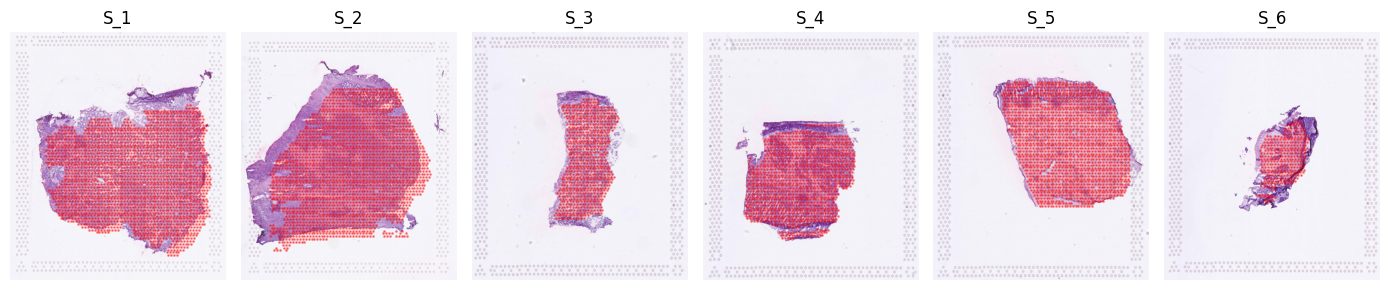

In [2]:
# Visualize Training slides with spot overlays
with h5py.File("data/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]

    num_train_slides = len(train_images)
    fig, ax = plt.subplots(1, num_train_slides, figsize=(14, 3))
    for i, slide_name in enumerate(train_images.keys()):
        image = np.array(train_images[slide_name])
        spots = np.array(train_spots[slide_name])
        x, y = spots["x"], spots["y"]

        ax[i].imshow(image, aspect="auto")
        ax[i].scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
        ax[i].set_title(slide_name)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
image.shape

(2000, 1930, 3)

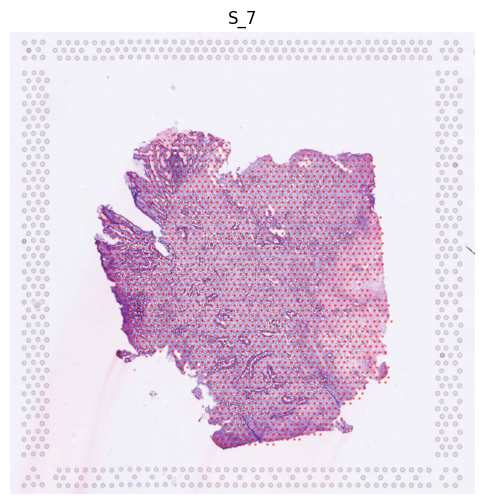

In [4]:
# Visualize Test slide ('S_7')
with h5py.File("data/elucidata_ai_challenge_data.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    test_spots = h5file["spots/Test"]
    
    sample = 'S_7'
    image = np.array(test_images[sample])
    spots = np.array(test_spots[sample])
    x, y = spots["x"], spots["y"]

    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [11]:
train_spot_tables['S_1'].describe().T

,count,mean,std,min,25%,50%,75%,max
x,2197.0,1146.659536,401.366578,3.310000e+02,805.000000,1186.000000,1489.000000,1830.000000
y,2197.0,1164.367319,283.388030,5.870000e+02,930.000000,1159.000000,1388.000000,1800.000000
C1,2197.0,0.121815,0.396917,1.054997e-05,0.011094,0.029458,0.088499,12.331591
C2,2197.0,0.089254,0.113085,2.842069e-04,0.023592,0.054229,0.111918,1.136348
C3,2197.0,0.093587,0.228187,8.477953e-05,0.017118,0.037990,0.077623,4.262972
C4,2197.0,0.015726,0.033874,8.944649e-07,0.000616,0.002307,0.013283,0.392290
C5,2197.0,1.699786,2.343692,4.906088e-05,0.025667,0.542953,2.672716,15.887546
C6,2197.0,0.387921,0.599160,4.096498e-07,0.002542,0.093118,0.584545,4.587440
C7,2197.0,0.037654,0.043559,1.805113e-05,0.008185,0.022497,0.051259,0.393281
C8,2197.0,0.011725,0.045832,1.104230e-07,0.000191,0.001235,0.006247,1.094625


# 2. Loading and Displaying Spots Tables

The following cells load and display the (x, y) coordinates and cell type annotations for Train slides and the spot coordinates for the Test slide.  

In [8]:
import pandas as pd

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("data/elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,1554,1297,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,0.020029,...,1.009572e-03,2.068237,0.121361,0.007344,0.000017,0.036891,0.035934,0.118937,0.001472,0.050057
1,462,1502,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,0.001711,...,6.918171e-04,0.014442,0.000238,0.024071,0.000023,0.217589,0.100662,0.004027,0.004122,0.049491
2,1488,1548,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,0.000114,...,9.577447e-05,0.149792,0.001401,0.000699,0.000009,0.024491,0.018810,0.004171,0.000425,0.015348
3,1725,1182,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,0.010154,...,1.964150e-03,0.142549,0.002036,0.047165,0.000022,0.180372,0.202981,0.003709,0.001845,0.116022
4,581,1113,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,0.000468,...,7.189078e-05,0.005920,0.000048,0.006359,0.000585,0.052661,0.032168,0.000107,0.000107,0.013103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,1055,701,0.047236,0.112721,0.052490,0.002092,0.000913,0.393805,0.045220,0.013414,...,7.530558e-03,0.559967,0.154793,0.133587,0.000013,0.051041,0.113100,0.003147,0.004971,0.128265
2193,1225,862,0.070764,0.119310,0.193938,0.001239,0.003851,0.588956,0.037731,0.004072,...,3.219223e-02,0.667076,0.094247,0.136623,0.000009,0.050518,0.119685,0.027743,0.016413,0.287171
2194,765,1479,0.194491,0.048068,0.150061,0.002978,0.119206,0.000213,0.005332,0.000078,...,2.628421e-04,0.000273,0.000022,0.000027,0.000042,0.029386,0.019977,0.000039,0.000119,0.006778
2195,607,1525,0.002968,0.151899,0.015931,0.000071,1.354983,0.000152,0.019254,0.001267,...,1.377452e-03,0.003754,0.001420,0.088000,0.000536,0.073240,0.113631,0.009040,0.000090,0.025716


In [ ]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("/kaggle/input/el-hackathon-2025/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

# 3. Creating a Random Submission

In this section, we generate random predictions for the 35 cell types.  
The predictions are random floats between 0 and 2 (without any normalization) for each spot in the Test slide.  
The order of spots is preserved as in the test spots table.

In [6]:
# Create a random submission
# (predictions of cell type abundances for 35 classes across the Test slide spots;
# spot order should be same as in the 'Test' spots table)

# Use the cell type columns from the train spots table; assuming first two columns are (x, y)
cell_type_columns = train_spot_tables['S_1'].columns[2:].values  # Expecting 35 cell types here
indices = test_spot_table.index.values  # All spots on the Test slide

# Create a 2D array of random floats between 0 and 2 for each spot and cell type
prediction_matrix = 2 * np.random.rand(len(indices), len(cell_type_columns))
predicted_labels = pd.DataFrame(prediction_matrix, columns=cell_type_columns, index=indices)

predicted_labels.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,0.611859,0.979330,0.901195,0.385157,0.903516,0.345256,0.547072,1.129464,0.620658,0.194200,...,1.524115,0.125547,1.993981,0.968223,0.336914,1.184162,0.914060,0.527346,0.713019,1.416672
1,1.819617,0.222662,0.761490,1.552526,1.361109,0.112154,0.590111,0.030387,0.437949,1.477419,...,1.416686,1.622750,0.952412,1.273203,0.720482,1.109188,1.204166,1.998883,1.526737,1.153066
2,1.518845,1.056532,1.652095,0.791393,0.012864,1.239347,0.990548,1.731604,0.559827,0.766080,...,1.857956,0.513035,0.171443,1.132187,0.900618,0.298093,0.170911,1.898718,1.394505,1.908267
3,0.528153,0.078265,1.658052,0.632933,0.892483,1.177548,0.079539,1.871063,1.543816,0.013649,...,1.723247,1.279911,0.341572,1.164254,0.287193,0.134563,1.885985,1.700673,1.411032,1.442410
4,1.277759,0.157414,1.715797,1.999455,1.360243,1.432327,0.882750,0.263458,0.200988,0.436135,...,1.360714,0.121534,1.889956,0.547792,1.142760,1.259616,0.009594,0.516334,0.463927,0.942226


# 4. Submission File Generation

Finally, we generate the submission file in the required format.  
Each row corresponds to a test spot with its identifier (constructed here as the index) followed by 35 predictions.

In [7]:
# Prepare submission DataFrame: spot_id column and then predictions for each cell type
submission_df = predicted_labels.copy()
submission_df.insert(0, 'ID', submission_df.index)

# Save the submission file as submission.csv
submission_df.to_csv("./submission.csv", index=False)
print("Submission file 'submission.csv' created!")

Submission file 'submission.csv' created!
